<h2>Different Classiffieres on Ordered Dataset</h2>

<h4>Read data from file</h4>

In [2]:
import pandas as pd


file_path = './facial_expressions_with_grade_groups_feb_2024.csv'
facial_expressions_data = df = pd.read_csv(file_path, low_memory=False)

<h3>Create train and validations datasets with random samples</h3>

In [3]:
from datetime import datetime
from sklearn.model_selection import train_test_split
import pandas as pd

selected_features = ['Jaw Drop', 'Lip Corner Depressor', 'Lip Suck','Lip Stretch', 'Nose Wrinkle', 'Yaw']

dataset = facial_expressions_data[selected_features + ['Respondent'] + ['Grade Group']]

# Identify the unique respondent IDs
respondent_ids = dataset['Respondent'].unique()

# Set the number of samples to select for each participant in the training set
num_samples_per_participant_train = 10000

# Set the number of participants for validation
num_participants_validation = 5

# Randomly select 11 participants for training
train_participants, validation_participants = train_test_split(respondent_ids, 
                                                               test_size=num_participants_validation, 
                                                               random_state=42)

# Create an empty DataFrame to store the selected training samples
selected_training_samples = pd.DataFrame(columns=dataset.columns)

# Select the first 10,000 samples from each respondent
for participant_id in train_participants:
    participant_data = dataset[dataset['Respondent'] == participant_id].head(num_samples_per_participant_train)
    selected_training_samples = selected_training_samples.append(participant_data)

# Create training set using the selected training samples
train_set = selected_training_samples

# Create validation set using all rows for the randomly selected 5 participants
validation_set = dataset[dataset['Respondent'].isin(validation_participants)]

# Save the datasets with UTC timestamp
timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
train_set.to_csv(f"./datasets/ordered/train_set_{timestamp}.csv", index=False)
validation_set.to_csv(f"./datasets/ordered/validation_set_{timestamp}.csv", index=False)


C:\Users\user\AppData\Local\Temp\ipykernel_67444\1547800894.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_training_samples = selected_training_samples.append(participant_data)
C:\Users\user\AppData\Local\Temp\ipykernel_67444\1547800894.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_training_samples = selected_training_samples.append(participant_data)
C:\Users\user\AppData\Local\Temp\ipykernel_67444\1547800894.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_training_samples = selected_training_samples.append(participant_data)
C:\Users\user\AppData\Local\Temp\ipykernel_67444\1547800894.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

<h4>Random Forest</h4>

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Read the datasets before training the classifier
train_set = pd.read_csv(f"./datasets/ordered/train_set_{timestamp}.csv")
validation_set = pd.read_csv(f"./datasets/ordered/validation_set_{timestamp}.csv")

# X_train = train_set.drop('Respondent', axis=1)
X_train = train_set.drop(['Respondent', 'Grade Group'], axis=1)
y_train = train_set['Grade Group']

X_validation = validation_set.drop(['Grade Group', 'Respondent'], axis=1)
y_validation = validation_set['Grade Group']

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
predictions = rf_classifier.predict(X_validation)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_validation, predictions)
print(f"Accuracy on the validation set: {accuracy}")
print("Accuracy:", accuracy_score(y_validation, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_validation, predictions))
print("Classification Report:\n", classification_report(y_validation, predictions))

Accuracy on the validation set: 0.3741796475645014
Accuracy: 0.3741796475645014
Confusion Matrix:
 [[ 59679  34231]
 [136556  42435]]
Classification Report:
               precision    recall  f1-score   support

    Above 55       0.30      0.64      0.41     93910
    Below 55       0.55      0.24      0.33    178991

    accuracy                           0.37    272901
   macro avg       0.43      0.44      0.37    272901
weighted avg       0.47      0.37      0.36    272901



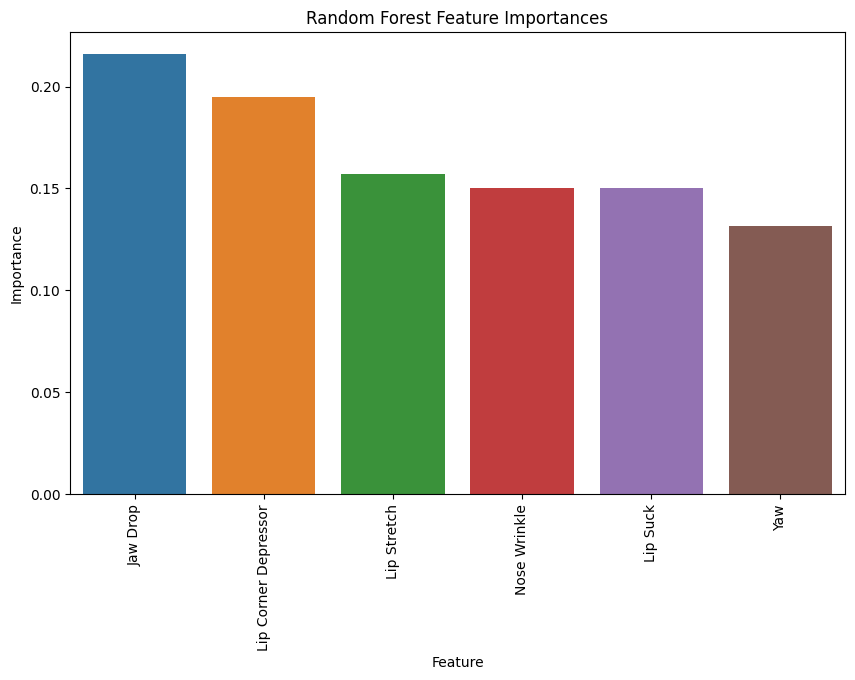

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the feature importances
importances = rf_classifier.feature_importances_
features = X_train.columns

# Sort the importances in descending order
sorted_importances = sorted(zip(importances, features), reverse=True)

# Extract the sorted feature importances and feature names
sorted_feature_importances = [x[0] for x in sorted_importances]
sorted_feature_names = [x[1] for x in sorted_importances]

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_names, y=sorted_feature_importances)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()

<h3>RNN Classifier - sequence length of 100</h3>

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder


# Read the datasets before training the classifier
train_set = pd.read_csv(f"./datasets/ordered/train_set_{timestamp}.csv")
validation_set = pd.read_csv(f"./datasets/ordered/validation_set_{timestamp}.csv")

# Select features and target
selected_features = ['Jaw Drop', 'Lip Corner Depressor', 'Lip Suck', 'Lip Stretch', 'Nose Wrinkle', 'Yaw']
target_feature = 'Grade Group'

# Convert the Grade Group label
label_encoder = LabelEncoder()
train_set['Grade Group'] = label_encoder.fit_transform(train_set['Grade Group'])
validation_set['Grade Group'] = label_encoder.transform(validation_set['Grade Group'])

# Normalize the features
scaler = StandardScaler()
train_set[selected_features] = scaler.fit_transform(train_set[selected_features])
validation_set[selected_features] = scaler.transform(validation_set[selected_features])

# Create sequences for time series data
def create_sequences(data, sequence_length=100):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][selected_features].values
        label = data.iloc[i+sequence_length][target_feature]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 10  
X_train, y_train = create_sequences(train_set, sequence_length)
X_validation, y_validation = create_sequences(validation_set, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_validation, y_validation))

# Evaluate the model on the validation set
y_pred_prob = model.predict(X_validation)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_validation, y_pred)
print(f"Accuracy on the validation set: {accuracy}")
print("Confusion Matrix:\n", confusion_matrix(y_validation, y_pred))
print("Classification Report:\n", classification_report(y_validation, y_pred))


Epoch 1/10
3438/3438 [==============================] - 38s 11ms/step - loss: 0.5855 - accuracy: 0.6758 - val_loss: 1.0130 - val_accuracy: 0.4558
Epoch 2/10
3438/3438 [==============================] - 35s 10ms/step - loss: 0.5157 - accuracy: 0.7364 - val_loss: 0.9682 - val_accuracy: 0.5341
Epoch 3/10
3438/3438 [==============================] - 38s 11ms/step - loss: 0.4809 - accuracy: 0.7624 - val_loss: 1.0914 - val_accuracy: 0.5134
Epoch 4/10
3438/3438 [==============================] - 46s 13ms/step - loss: 0.4594 - accuracy: 0.7752 - val_loss: 1.1880 - val_accuracy: 0.5083
Epoch 5/10
3438/3438 [==============================] - 37s 11ms/step - loss: 0.4435 - accuracy: 0.7855 - val_loss: 1.1411 - val_accuracy: 0.5336
Epoch 6/10
3438/3438 [==============================] - 36s 10ms/step - loss: 0.4300 - accuracy: 0.7937 - val_loss: 1.1550 - val_accuracy: 0.5885
Epoch 7/10
3438/3438 [==============================] - 36s 11ms/step - loss: 0.4189 - accuracy: 0.7999 - val_loss: 1.3477 -

AttributeError: 'Sequential' object has no attribute 'predict_classes'

<h3>RNN Classifier - sequence length of 1000</h3>

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping


# Read the datasets before training the classifier
train_set = pd.read_csv(f"./datasets/ordered/train_set_{timestamp}.csv")
validation_set = pd.read_csv(f"./datasets/ordered/validation_set_{timestamp}.csv")

# Select features and target
selected_features = ['Jaw Drop', 'Lip Corner Depressor', 'Lip Suck', 'Lip Stretch', 'Nose Wrinkle', 'Yaw']
target_feature = 'Grade Group'

# Convert the Grade Group label
label_encoder = LabelEncoder()
train_set['Grade Group'] = label_encoder.fit_transform(train_set['Grade Group'])
validation_set['Grade Group'] = label_encoder.transform(validation_set['Grade Group'])

# Normalize the features
scaler = StandardScaler()
train_set[selected_features] = scaler.fit_transform(train_set[selected_features])
validation_set[selected_features] = scaler.transform(validation_set[selected_features])

# Create sequences for time series data
def create_sequences(data, sequence_length=1000):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][selected_features].values
        label = data.iloc[i+sequence_length][target_feature]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 10  
X_train, y_train = create_sequences(train_set, sequence_length)
X_validation, y_validation = create_sequences(validation_set, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Evaluate the model on the validation set
y_pred_prob = model.predict(X_validation)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_validation, y_pred)
print(f"Accuracy on the validation set: {accuracy}")
print("Confusion Matrix:\n", confusion_matrix(y_validation, y_pred))
print("Classification Report:\n", classification_report(y_validation, y_pred))


Epoch 1/100
3438/3438 [==============================] - 38s 11ms/step - loss: 0.5869 - accuracy: 0.6750 - val_loss: 1.0362 - val_accuracy: 0.4395
Epoch 2/100
3438/3438 [==============================] - 36s 10ms/step - loss: 0.5137 - accuracy: 0.7384 - val_loss: 1.0480 - val_accuracy: 0.4842
Epoch 3/100
3438/3438 [==============================] - 37s 11ms/step - loss: 0.4775 - accuracy: 0.7645 - val_loss: 0.9819 - val_accuracy: 0.5391
Epoch 4/100
3438/3438 [==============================] - 39s 11ms/step - loss: 0.4568 - accuracy: 0.7792 - val_loss: 1.1487 - val_accuracy: 0.5504
Epoch 5/100
3438/3438 [==============================] - 38s 11ms/step - loss: 0.4405 - accuracy: 0.7878 - val_loss: 1.3622 - val_accuracy: 0.4892
Epoch 6/100
8528/8528 [==============================] - 21s 2ms/step
Accuracy on the validation set: 0.5391310083513198
Confusion Matrix:
 [[56278 37622]
 [88145 90846]]
Classification Report:
               precision    recall  f1-score   support

         0.0   

<h3>RNN Classifier - sequence length of 2000</h3>

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping


# Read the datasets before training the classifier
train_set = pd.read_csv(f"./datasets/ordered/train_set_{timestamp}.csv")
validation_set = pd.read_csv(f"./datasets/ordered/validation_set_{timestamp}.csv")

# Select features and target
selected_features = ['Jaw Drop', 'Lip Corner Depressor', 'Lip Suck', 'Lip Stretch', 'Nose Wrinkle', 'Yaw']
target_feature = 'Grade Group'

# Convert the Grade Group label
label_encoder = LabelEncoder()
train_set['Grade Group'] = label_encoder.fit_transform(train_set['Grade Group'])
validation_set['Grade Group'] = label_encoder.transform(validation_set['Grade Group'])

# Normalize the features
scaler = StandardScaler()
train_set[selected_features] = scaler.fit_transform(train_set[selected_features])
validation_set[selected_features] = scaler.transform(validation_set[selected_features])

# Create sequences for time series data
def create_sequences(data, sequence_length=4000):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][selected_features].values
        label = data.iloc[i+sequence_length][target_feature]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 10  
X_train, y_train = create_sequences(train_set, sequence_length)
X_validation, y_validation = create_sequences(validation_set, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Evaluate the model on the validation set
y_pred_prob = model.predict(X_validation)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_validation, y_pred)
print(f"Accuracy on the validation set: {accuracy}")
print("Confusion Matrix:\n", confusion_matrix(y_validation, y_pred))
print("Classification Report:\n", classification_report(y_validation, y_pred))


Epoch 1/100
3438/3438 [==============================] - 38s 11ms/step - loss: 0.5869 - accuracy: 0.6750 - val_loss: 1.0362 - val_accuracy: 0.4395
Epoch 2/100
3438/3438 [==============================] - 36s 10ms/step - loss: 0.5137 - accuracy: 0.7384 - val_loss: 1.0480 - val_accuracy: 0.4842
Epoch 3/100
3438/3438 [==============================] - 37s 11ms/step - loss: 0.4775 - accuracy: 0.7645 - val_loss: 0.9819 - val_accuracy: 0.5391
Epoch 4/100
3438/3438 [==============================] - 39s 11ms/step - loss: 0.4568 - accuracy: 0.7792 - val_loss: 1.1487 - val_accuracy: 0.5504
Epoch 5/100
3438/3438 [==============================] - 38s 11ms/step - loss: 0.4405 - accuracy: 0.7878 - val_loss: 1.3622 - val_accuracy: 0.4892
Epoch 6/100
8528/8528 [==============================] - 21s 2ms/step
Accuracy on the validation set: 0.5391310083513198
Confusion Matrix:
 [[56278 37622]
 [88145 90846]]
Classification Report:
               precision    recall  f1-score   support

         0.0   

In [12]:
# Evaluate the model on the validation set
y_pred_prob = model.predict(X_validation)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on the validation set
accuracy = accuracy_score(y_validation, y_pred)
print(f"Accuracy on the validation set: {accuracy}")
print("Confusion Matrix:\n", confusion_matrix(y_validation, y_pred))
print("Classification Report:\n", classification_report(y_validation, y_pred))

8528/8528 [==============================] - 20s 2ms/step
Accuracy on the validation set: 0.5391310083513198
Confusion Matrix:
 [[56278 37622]
 [88145 90846]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.39      0.60      0.47     93900
         1.0       0.71      0.51      0.59    178991

    accuracy                           0.54    272891
   macro avg       0.55      0.55      0.53    272891
weighted avg       0.60      0.54      0.55    272891

